In [1]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git


In [2]:
# Imports

from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from adni.load_data import load_data
import warnings
warnings.filterwarnings('ignore')


In [3]:
# Function for plotting learning curves

def plot_learning_curve(estimator, title, X, y, axes=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generates 1 plot: the test and training learning curve.
    """
    axes.set_title(title)
    # if ylim is not None:
    #    axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores, _, _ = \
        learning_curve(estimator, X, y, cv=StratifiedKFold(n_splits=10), n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                      train_scores_mean + train_scores_std, alpha=0.1,
                      color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                      test_scores_mean + test_scores_std, alpha=0.1,
                      color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
              label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
              label="Cross-validation score")
    axes.legend(loc="best")

    return plt


In [4]:
# Load data
DATA = load_data()


In [5]:
# Describe data
AMOUNT_SAMPLES = len(DATA.index)
AMOUNT_FEATURES = len(DATA.columns)
print(f'The number of samples: {AMOUNT_SAMPLES}')
print(f'The number of columns: {AMOUNT_FEATURES}')

AMOUNT_AD = sum(DATA['label'] == 'AD')
AMOUNT_CN = sum(DATA['label'] == 'CN')
RATIO_AD = AMOUNT_AD/AMOUNT_SAMPLES
RATIO_CN = AMOUNT_CN/AMOUNT_SAMPLES
print(f'The number of AD samples: {AMOUNT_AD} ({round(RATIO_AD*100,2)}%)')
print(f'The number of CN samples: {AMOUNT_CN} ({round(RATIO_CN*100,2)}%)')


The number of samples: 855
The number of columns: 268
The number of AD samples: 519 (60.7%)
The number of CN samples: 336 (39.3%)


In [6]:
# Extract information
# Get dataframe X with all features and dataframe Y with labels
X = DATA
X = X.drop(['label'], axis=1)
Y = DATA['label']

# Function for outer cross validation
CV_10FOLD = StratifiedKFold(n_splits=10)

# Lists for AUC scores
AUC_KNN = []
AUC_RF = []
AUC_SVM = []

# Lists for sensitivity scores
SENS_KNN = []
SENS_RF = []
SENS_SVM = []

# Lists for specificity scores
SPEC_KNN = []
SPEC_RF = []
SPEC_SVM = []

# lists for different hyperparameter sets
PAR_KNN = []
PAR_RF = []
PAR_SVM = []

In [7]:
# Outer and inner crossvalidation
for train_index, test_index in CV_10FOLD.split(X, Y):
    # Split the data
    X_TRAIN = X.iloc[train_index]
    Y_TRAIN = Y.iloc[train_index]

    X_TEST = X.iloc[test_index]
    Y_TEST = Y.iloc[test_index]

    # PREPROCESSING

    # Remove duplicates in X and corresponding Y
    DUPLICATES = X_TRAIN[X_TRAIN.duplicated(keep='first')]
    DUPLICATES_ID = DUPLICATES.index
    X_TRAIN = X_TRAIN.drop(DUPLICATES_ID)
    Y_TRAIN = Y_TRAIN.drop(DUPLICATES_ID)

    DUPLICATES_TEST = X_TEST[X_TEST.duplicated(keep='first')]
    DUPLICATES_ID_TEST = DUPLICATES_TEST.index
    X_TEST = X_TEST.drop(DUPLICATES_ID_TEST)
    Y_TEST = Y_TEST.drop(DUPLICATES_ID_TEST)

    # Binarize labels
    LB = preprocessing.LabelBinarizer()
    Y_TRAIN = LB.fit_transform(Y_TRAIN)
    Y_TEST = LB.fit_transform(Y_TEST)

    # Remove duplicate features
    X_TRAIN = X_TRAIN.T.drop_duplicates().T
    X_TEST = X_TEST.T.drop_duplicates().T

    # Remove empty columns
    EMPTY_COLS = X_TRAIN.columns[(X_TRAIN == 0).sum() > 0.8*X_TRAIN.shape[0]]
    X_TRAIN = X_TRAIN.drop(X_TRAIN[EMPTY_COLS], axis=1)

    EMPTY_COLS_TEST = X_TEST.columns[(X_TEST == 0).sum() > 0.8*X_TEST.shape[0]]
    X_TEST = X_TEST.drop(X_TEST[EMPTY_COLS_TEST], axis=1)

    # Removal of columns with same values
    NUNIQUE = X_TRAIN.apply(pd.Series.nunique)
    SAME_COLS = NUNIQUE[NUNIQUE < 2].index
    X_TRAIN = X_TRAIN.drop(X_TRAIN[SAME_COLS], axis=1)

    NUNIQUE_TEST = X_TEST.apply(pd.Series.nunique)
    SAME_COLS_TEST = NUNIQUE_TEST[NUNIQUE < 2].index
    X_TEST = X_TEST.drop(X_TEST[SAME_COLS_TEST], axis=1)

    # Scaling: Robust range matching
    SCALER = preprocessing.RobustScaler()
    SCALER.fit(X_TRAIN)
    X_TRAIN = SCALER.transform(X_TRAIN)
    X_TEST = SCALER.transform(X_TEST)

    # CLASSIFIERS
    SCORE = {'accuracy': 'accuracy',
             'roc_auc': 'roc_auc'}
    REFIT = 'roc_auc'

    # Function for outer cross validation
    CV_5 = StratifiedShuffleSplit(n_splits=5, test_size=0.10, train_size=0.90)

    # K-Nearest Neighbors (KNN)
    print('start KNN')

    # Search for best hyperparameters for the combination of PCA and Nearest Neighbors
    PIPE_KNN = Pipeline([('pca', PCA()),
                         ('knn', KNeighborsClassifier())])

    # The set of hyperparameters to tune
    PARAMETERS_KNN = {'pca__n_components': [1, 2, 3, 4, 5, 10, 20, 50, 75],
                      'knn__n_neighbors': list(range(1, 75, 2)),
                      'knn__weights': ['uniform', 'distance']}

    CLF_KNN = RandomizedSearchCV(PIPE_KNN, cv=CV_5, n_jobs=-1, n_iter=100,
                                 param_distributions=PARAMETERS_KNN,
                                 scoring=SCORE, refit=REFIT)

    # Train
    CLF_KNN.fit(X_TRAIN, np.ravel(Y_TRAIN))

    # DataFrame of the results with the different hyperparameters
    DF_KNN = pd.DataFrame(CLF_KNN.cv_results_)

    CLF_KNN_BEST = CLF_KNN.best_estimator_
    PAR_KNN.append(CLF_KNN.best_params_)

    # Random Forest (RF)
    print('start RF')
    # Search for best hyperparameters for the combination of PCA and RandomForestClassifier
    PIPE_RF = Pipeline([('pca', PCA()),
                        ('rf', RandomForestClassifier())])

    # The set of hyperparameters to tune
    PARAMETERS_RF = {'pca__n_components': [1, 2, 3, 4, 5, 10, 20, 50, 75],
                     'rf__n_estimators': list(range(10, 200, 10)),
                     'rf__max_features': ['auto', 'sqrt'],
                     'rf__max_depth': list(range(10, 50, 10)),
                     'rf__min_samples_split': [2, 5, 10],
                     'rf__min_samples_leaf': [1, 2, 4],
                     'rf__bootstrap': [True, False]}

    CLF_RF = RandomizedSearchCV(PIPE_RF, cv=CV_5, n_jobs=-1, n_iter=100,
                                param_distributions=PARAMETERS_RF,
                                scoring=SCORE, refit=REFIT)

    # Train
    CLF_RF.fit(X_TRAIN, np.ravel(Y_TRAIN))

    # DataFrame of the results with the different hyperparameters
    DF_RF = pd.DataFrame(CLF_RF.cv_results_)

    CLF_RF_BEST = CLF_RF.best_estimator_
    PAR_RF.append(CLF_RF.best_params_)

    # Support Vector Machine (SVM)
    print('start SVM')
    # Search for best hyperparameters for the combination of PCA and SVM
    PIPE_SVM = Pipeline([('pca', PCA()),
                         ('svc', SVC())])

    # The set of hyperparameters to tune
    PARAMETERS_SVM = [{'svc__kernel': ['rbf'], 'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                       'svc__C': [0.01, 0.1, 0.5, 1, 10, 50, 100], 'svc__max_iter': [10000],
                       'pca__n_components': [1, 2, 3, 4, 5, 10, 20, 50, 75]},
                      {'svc__kernel': ['sigmoid'], 'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                       'svc__C': [0.01, 0.1, 0.5, 1, 10, 50, 100], 'svc__max_iter': [10000], 
                       'pca__n_components': [1, 2, 3, 4, 5, 10, 20, 50, 75]},
                      {'svc__kernel': ['poly'], 'svc__degree': [2, 3, 4, 5],
                       'svc__C': [0.01, 0.1, 0.5, 1, 10, 50, 100], 'svc__max_iter': [10000],
                       'pca__n_components': [1, 2, 3, 4, 5, 10, 20, 50, 75]}]

    CLF_SVM = RandomizedSearchCV(PIPE_SVM, cv=CV_5, n_jobs=-1, n_iter=100,
                                 param_distributions=PARAMETERS_SVM,
                                 scoring=SCORE, refit=REFIT)

    # Train
    CLF_SVM.fit(X_TRAIN, np.ravel(Y_TRAIN))

    # DataFrame of the results with the different hyperparameters
    DF_SVM = pd.DataFrame(CLF_SVM.cv_results_)

    CLF_SVM_BEST = CLF_SVM.best_estimator_
    PAR_SVM.append(CLF_SVM.best_params_)

    # Train with outer cross-validation
    CLF_KNN_BEST.fit(X_TRAIN, np.ravel(Y_TRAIN))
    CLF_RF_BEST.fit(X_TRAIN, np.ravel(Y_TRAIN))
    CLF_SVM_BEST.fit(X_TRAIN, np.ravel(Y_TRAIN))

    # get predictions
    KNN_prediction = CLF_KNN_BEST.predict(X_TEST)
    RF_prediction = CLF_RF_BEST.predict(X_TEST)
    SVM_prediction = CLF_SVM_BEST.predict(X_TEST)

    AUC_KNN.append(roc_auc_score(Y_TEST, KNN_prediction))
    AUC_RF.append(roc_auc_score(Y_TEST, RF_prediction))
    AUC_SVM.append(roc_auc_score(Y_TEST, SVM_prediction))

    TN_KNN, FP_KNN, FN_KNN, TP_KNN = confusion_matrix(Y_TEST, KNN_prediction).ravel()
    SPEC_KNN.append(TN_KNN / (TN_KNN+FP_KNN))
    SENS_KNN.append(TP_KNN / (TP_KNN+FN_KNN))

    TN_RF, FP_RF, FN_RF, TP_RF = confusion_matrix(Y_TEST, RF_prediction).ravel()
    SPEC_RF.append(TN_RF / (TN_RF+FP_RF))
    SENS_RF.append(TP_RF / (TP_RF+FN_RF))

    TN_SVM, FP_SVM, FN_SVM, TP_SVM = confusion_matrix(Y_TEST, SVM_prediction).ravel()
    SPEC_SVM.append(TN_SVM / (TN_SVM+FP_SVM))
    SENS_SVM.append(TP_SVM / (TP_SVM+FN_SVM))

    print('a crossvalidation set was run')


start KNN
start RF
start SVM
a crossvalidation set was run
start KNN
start RF
start SVM
a crossvalidation set was run
start KNN
start RF
start SVM
a crossvalidation set was run
start KNN
start RF
start SVM
a crossvalidation set was run
start KNN
start RF
start SVM
a crossvalidation set was run
start KNN
start RF
start SVM
a crossvalidation set was run
start KNN
start RF
start SVM
a crossvalidation set was run
start KNN
start RF
start SVM
a crossvalidation set was run
start KNN
start RF
start SVM
a crossvalidation set was run
start KNN
start RF
start SVM
a crossvalidation set was run


In [8]:
# learning curves

# PREPROCESSING X AND Y

# Remove duplicates in X and corresponding Y
DUPLICATES = X[X.duplicated(keep='first')]
DUPLICATES_ID = DUPLICATES.index
X = X.drop(DUPLICATES_ID)
Y = Y.drop(DUPLICATES_ID)

# Binarize labels
LB = preprocessing.LabelBinarizer()
Y = LB.fit_transform(Y)

# Remove duplicate features
X = X.T.drop_duplicates().T

# Remove empty columns
EMPTY_COLS = X.columns[(X == 0).sum() > 0.8*X.shape[0]]
X = X.drop(X[EMPTY_COLS], axis=1)

# Removal of columns with same values
NUNIQUE = X.apply(pd.Series.nunique)
SAME_COLS = NUNIQUE[NUNIQUE < 2].index
X = X.drop(X[SAME_COLS], axis=1)

# Scaling: Robust range matching
SCALER = preprocessing.RobustScaler()
SCALER.fit(X)
X = SCALER.transform(X)


Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=75,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('knn',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=61, p=2,
                                      weights='distance'))],
         verbose=False)
KNN
RF
SVM


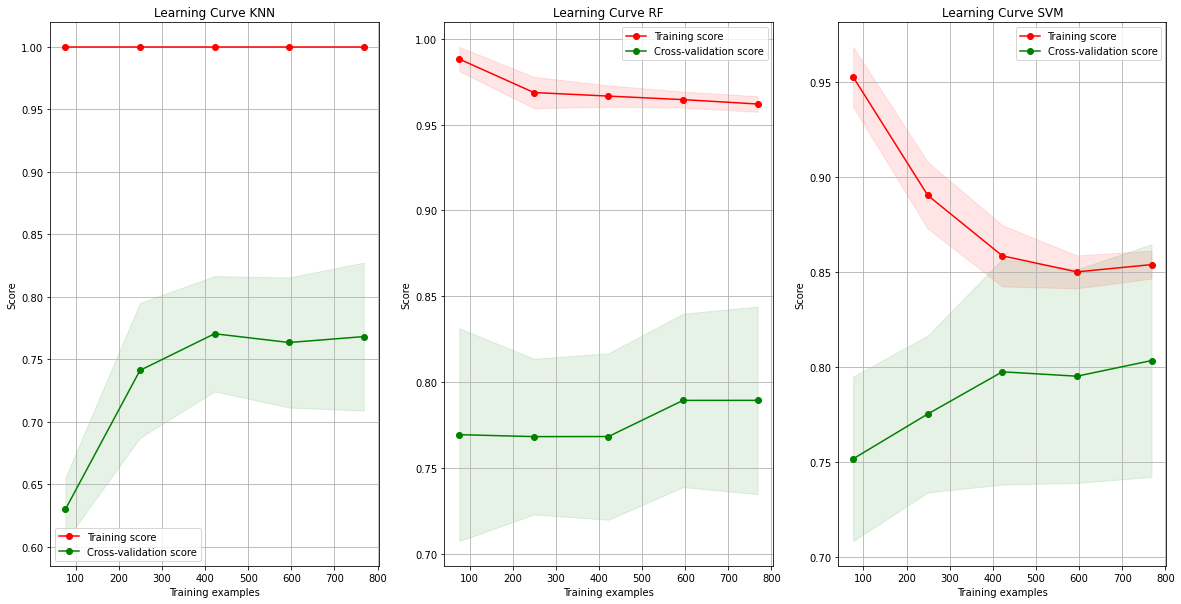

In [9]:
# plot learning curves
CLFS = [CLF_KNN_BEST, CLF_RF_BEST, CLF_SVM_BEST]
print(CLF_KNN_BEST)
TITLE_CLF = ['KNN', 'RF', 'SVM']

fig, AXES = plt.subplots(1, 3, figsize=(20, 10))
NUM = 0
for CLF, TITLE_CLF in zip(CLFS, TITLE_CLF):
    print(TITLE_CLF)
    title = f'Learning Curve {TITLE_CLF}'
    plot_learning_curve(CLF, title, X, np.ravel(Y), axes=AXES[NUM])
    NUM += 1
fig.savefig(f'learning_curves 3 classifiers.png')
plt.show()


In [10]:
# get results

# Create df with AUC-values of the tree classifiers over the 10-fold cross validation
DF_AUC_RESULTS = pd.DataFrame({'KNN': list(AUC_KNN),
                               'RF': list(AUC_RF),
                               'SVM': list(AUC_SVM)})
DF_AUC_RESULTS.loc['mean'] = DF_AUC_RESULTS.mean()
DF_AUC_RESULTS['best_clf'] = DF_AUC_RESULTS.idxmax(axis=1)
DF_AUC_RESULTS.loc['std'] = DF_AUC_RESULTS.std()
print('AUC for 10 crossvalidations for KNN, RF and SVM:')
print()
print(DF_AUC_RESULTS)
DF_AUC_RESULTS.to_csv('df_AUC_results.csv')

# Create df with specificities
DF_SPEC_RESULTS = pd.DataFrame({'KNN': list(SPEC_KNN),
                                'RF': list(SPEC_RF),
                                'SVM': list(SPEC_SVM)})
DF_SPEC_RESULTS.loc['mean'] = DF_SPEC_RESULTS.mean()
DF_SPEC_RESULTS.loc['std'] = DF_SPEC_RESULTS.std()
print()
print('specificity for 10 crossvalidations for KNN, RF and SVM:')
print()
print(DF_SPEC_RESULTS)
DF_SPEC_RESULTS.to_csv('df_SPEC_results.csv')

# Create df with sensitivities
DF_SENS_RESULTS = pd.DataFrame({'KNN': list(SENS_KNN),
                                'RF': list(SENS_RF),
                                'SVM': list(SENS_SVM)})
DF_SENS_RESULTS.loc['mean'] = DF_SENS_RESULTS.mean()
DF_SENS_RESULTS.loc['std'] = DF_SENS_RESULTS.std()
print()
print('sensitivity for 10 crossvalidations for KNN, RF and SVM:')
print()
print(DF_SENS_RESULTS)
DF_SENS_RESULTS.to_csv('df_SENS_results.csv')


AUC for 10 crossvalidations for KNN, RF and SVM:

           KNN        RF       SVM best_clf
0     0.731900  0.781109  0.820136      SVM
1     0.814480  0.824661  0.859163      SVM
2     0.754902  0.754902  0.700980      KNN
3     0.600113  0.639140  0.536765       RF
4     0.696833  0.731335  0.794683      SVM
5     0.837704  0.906469  0.805944       RF
6     0.764569  0.775641  0.785256      SVM
7     0.715035  0.745338  0.715035       RF
8     0.724650  0.805944  0.785256       RF
9     0.774510  0.769608  0.789216      SVM
mean  0.741470  0.773415  0.759243       RF
std   0.062805  0.065113  0.086155      NaN

specificity for 10 crossvalidations for KNN, RF and SVM:

           KNN        RF       SVM
0     0.846154  0.826923  0.846154
1     0.923077  0.884615  0.865385
2     0.921569  0.862745  0.843137
3     0.788462  0.807692  0.750000
4     0.923077  0.903846  0.942308
5     0.826923  0.903846  0.884615
6     0.923077  0.884615  0.903846
7     0.884615  0.884615  0.884615
8   

In [11]:
# print hyperparameters
print('Best hyper parameters for KNN in 10 crossvalidations')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(pd.DataFrame(PAR_KNN))
print()
print('Best hyper parameters for RF in 10 crossvalidations')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(pd.DataFrame(PAR_RF))
print()
print('Best hyper parameters for SVM in 10 crossvalidations')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(pd.DataFrame(PAR_SVM))


Best hyper parameters for KNN in 10 crossvalidations
   pca__n_components knn__weights  knn__n_neighbors
0                 75     distance                13
1                 50     distance                73
2                 75     distance                23
3                  4      uniform                45
4                 50      uniform                15
5                  3      uniform                65
6                 50      uniform                69
7                 10     distance                17
8                 20     distance                27
9                 75     distance                61

Best hyper parameters for RF in 10 crossvalidations
   rf__n_estimators  rf__min_samples_split  rf__min_samples_leaf  \
0                70                      2                     2   
1               180                      2                     4   
2               100                      2                     4   
3               120                      2        